# Performance of Image Decoder

In [20]:
%pylab inline
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Using a slightly altered version of a test function, `test_real_image`, we'll test the performance of `marsrover.rover_decode()`.  The image used for this test is `scikit-image moon()`.  Images in `scikit-image` are stored as numpy arrays, so are easy to manipulate using numpy operations for flattening and creating chunks.

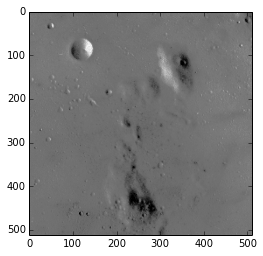

In [21]:
import numpy as np
from skimage.data import moon
plt.imshow(moon(), cmap='gray');

The `test_real_image` function does as follows:
    
    - Creates a 1d array of inidicies [0, size flattened image]
        - For 512x512 image, flattend image would be 262144 indicies
    - Dividies indicies to short, medium and long chunks
    - Merges all short chunks, with 1/3 sampling of medium chunks and 1/5 samples of long chunks.
        - The additional sampling ensures multiple paths to choose in graph.
    - Formats chunks to same format as sample data via `util_chunk2string`
    - Runs rover decoder: saves time it took to find optimal path.
    - Returns runtime and number of chunks/verticies in the graph.

In [22]:
from marsrover import rover_decode, util_chunks2string
import time

def test_real_image(image, L=15, B=10):
    """ Takes a real image of the moon (from scikit-image), flattens
    it, breaks it up into chunks, adds overlapping chunks, and tests
    that program reconstructs the full image.  
    """
    
    # Flatten image (which is just numpy array)
    # Store indicies (0,1,2,3) of length of flat image
    flat = image.flatten() 
    indicies = np.arange(len(flat))
    
    # Chunk numpy array using .split() into different length chunks,
    # and will merge short chunks with randomly selected longer chunks.
    # Divisors must be factors of the image size: 262144 for a 512x512
    short = len(flat) / 4  
    medium = len(flat) / 16
    longer = len(flat) / 64 
    
    def chunk_intvl(array, chunksize):
        """ Split 1-D array into N chunks of size, "chunksize".  
        Returns intervals of chunks (1,5) instead of chunk (1,2,3,4,5)
        """
        split = np.split(array, chunksize)
        # s[-1]+1 ensures overlap eg (0,200) (200,400)
        return [(s[0], s[-1]+1) for s in split]
        
    short_chunks = chunk_intvl(indicies, short)
    medium_chunks = chunk_intvl(indicies, medium)
    longer_chunks = chunk_intvl(indicies, longer)
    
    # Pass in all short chunks, pepper in 1/3 medium and 1/5 longer
    all_chunks = short_chunks + medium_chunks[::3] + longer_chunks[::5]
    
    stream = util_chunks2string(all_chunks, L, B)            
    start = time.time()
    _, path = rover_decode(stream, return_path=True)        
    total_time = time.time() - start
    return total_time, len(all_chunks)

We can test performance by slicing the image from an 8x8 square all the way up to the full 512 by 512 image.  Small images will process quickly, so we'll sample many datapoints from image slices 8,64; sample every 5th size on range 64 to 128 pixels, and finally sample only a few sizes on range 100-512.

In [23]:
testsize = range(8,64)[::2]+range(64,128)[::5]

To be clear, here's what the 8x8, 64x64 and 128x128 samples of the moon image look like:

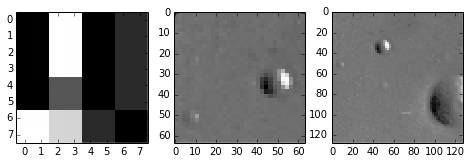

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4))
imgkwds = dict(cmap='gray', interpolation='none')

ax1.imshow(moon()[0:8, 0:8], **imgkwds)
ax2.imshow(moon()[0:64, 0:64], **imgkwds)
ax3.imshow(moon()[0:128, 0:128], **imgkwds);

In [25]:
times = []
chunk_count = []
for i in testsize:
    transfer_time, chunk_size = test_real_image(moon()[0:i, 0:i])
    times.append(transfer_time)
    chunk_count.append(chunk_size)

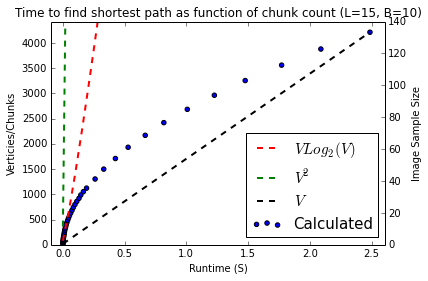

In [46]:
pltkwds = dict(lw=2, ls='--')

# Generate theoretical values
test_times = np.linspace(times[0], times[-1])
test_counts = np.linspace(chunk_count[0], chunk_count[-1])

# VLogV and V**2 
vlogv = [v * np.log2(v) for v in test_counts]
v2 = test_counts**2

plt.scatter(times,chunk_count, label='Calculated')
plt.plot(test_times,vlogv,color='r', label='$VLog_2(V)$', **pltkwds)
plt.plot(test_times,v2, color='g', label='$V^2$', **pltkwds)
plt.plot(test_times,test_counts, color='k', label='$V$', **pltkwds)

plt.ylim(0,chunk_count[-1] * 1.05) #Add some padding
plt.ylabel('Verticies/Chunks')
plt.xlabel('Runtime (S)')
plt.legend(loc='lower right', fontsize=15)

# Add right yaxis (plot invisible line basically)
plt.twinx()
plt.plot(test_times,np.linspace(0,testsize[-1]), alpha=0)
plt.ylabel("Image Sample Size")
plt.xlim(-.1, test_times[-1] * 1.05)

plt.title('Time to find shortest path as function of chunk count (L=15, B=10)');

$Vlog_2(V)+E$ is the theoretical worst case for the min-priority-queue implementation of Dijkstra's Algorithm [(according to wiki)](http://en.wikipedia.org/wiki/Dijkstra%27s_algorithm), and $V^2$ is the worst case of its original implementation.  Note that I only plotted $Vlog_2(V)$, and dropped the $E$ offset, so the red curve actually should be shifted up.  The decoder doesn't return the edge count, so $E$ isn't accessible.  In any case, we see that for **only this particular image and this set of chunk sizes, and chunk redundancy and these particular choices of Latency (L) and Bandwidth (B)**, the performance of the algorithm is pretty good.  A true analysis of performance should test a variety of chunk sizes and chunk overlap, as well as scaling L and B.  

In regard to runtime, running in the notebook slowed performance severely.  For example, running this test outside of the notebook environment ran the full (512x512) image in **12 seconds**, and **only took 0.5 seconds to run 128 image sample!**  Therefore, this performance tests should be retested outside of the notebook environment, and they are underestimating the speed of the algorithm.  I'm testing on a very slow 32bit laptop as well, so these speeds aren't representative of an average user.